## Business Understanding

This project aims to solve the problem of automatically classifying musical chords as either major or minor using audio input. Chord identification is a key task in music analysis, and automating it can save time on transcription and harmonic analysis. By using machine learning and music information retrieval (MIR) techniques, the goal is to create a tool that helps musicians, producers, and educators analyze music in real-time. The project focuses on making chord recognition more accessible and efficient, benefiting both students and professionals in the music industry.

---

## Tools/Methodologies

To handle the workflow, I'll use several Python libraries:

- [librosa](https://librosa.org/doc/latest/index.html) for extracting audio features, [numpy](https://numpy.org/doc/1.24/reference/index.html#reference) and [pandas](https://pandas.pydata.org/docs/reference/index.html#api) for data manipulation, and os and [Kaggle CLI](https://www.kaggle.com/code/donkeys/kaggle-python-api) to download the data directly into the notebook.
- [matplotlib](https://matplotlib.org/stable/api/index.html) and [seaborn](https://seaborn.pydata.org/api.html) for exploring and visualizing features like waveforms and spectrograms.
- [scikit-learn](https://scikit-learn.org/stable/api/index.html) for baseline models (e.g., logistic regression, SVM), and [tensorflow](https://www.tensorflow.org/api_docs/python/tf/all_symbols) or [keras](https://keras.io/api/) for building CNNs.

In [2]:
# Data manipulation
import numpy as np
import pandas as pd
import sklearn
import random
import time
import json
import os

# Audio feature extraction
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import find_peaks

# for Kaggle CLI
from kaggle.api.kaggle_api_extended import KaggleApi

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine learning models and utilities
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer

# Deep learning for CNNs
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Dropout, GlobalAveragePooling2D, TimeDistributed
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


## Data Understanding
The dataset used in this project is sourced from the [Musical Instrument Chord Classification (Audio)](https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification) dataset on Kaggle. It contains audio files `.wav` format of chords played on two instruments: guitar and piano. The raw data has been scraped from various sources and is already available for download on Kaggle, eliminating the need for manual data collection. The dataset is well-suited for this project, as it provides a clear distinction between major and minor chords, which is the focus of the classification task.

The features for the model will be extracted from the audio files using techniques such as Mel-frequency cepstral coefficients (MFCCs) or spectrograms, which capture important frequency and temporal information from the audio signals. Although other individuals may have used this dataset for similar chord classification tasks, this project will build upon existing work by focusing specifically on distinguishing between major and minor chords, potentially improving upon current models or exploring new machine learning techniques for this type of classification.

In [3]:
# uncomment if replicating project
# !pip install kaggle

In [4]:
# Load kaggle.json credentials
api_config_path = os.path.join(os.getcwd(), 'kaggle.json')
with open(api_config_path, 'r') as f:
    kaggle_config = json.load(f)

# Set environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Ensure the 'dataset' folder exists
dataset_dir = os.path.join(os.getcwd(), 'dataset')
os.makedirs(dataset_dir, exist_ok=True)

# Use the Kaggle API to download the dataset
api.dataset_download_files('deepcontractor/musical-instrument-chord-classification',
                           path=dataset_dir, unzip=True)

print("Dataset downloaded and extracted to:", dataset_dir)

Dataset URL: https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification
Dataset downloaded and extracted to: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset


In [5]:
# Define the base directory where the audio files are stored
base_dir = os.path.join(os.getcwd(), 'dataset', 'Audio_Files')

# Prepare to collect file details
file_details = []

# Loop through each category directory ('Major' and 'Minor')
for category in ['Major', 'Minor']:
    category_dir = os.path.join(base_dir, category)
    
    for filename in os.listdir(category_dir):
        if filename.endswith('.wav'):
            # Full path to file
            file_path = os.path.join(category_dir, filename)
            # Append the file path, filename (used as ID), and label to the list
            file_details.append({'path': file_path, 'id': filename, 'label': category})

# Save collected file details as a DataFrame
file_data = pd.DataFrame(file_details)

file_data.head()

,path,id,label
0,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_0.wav,Major
1,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_1.wav,Major
2,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_10.wav,Major
3,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_100.wav,Major
4,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_101.wav,Major


## Music and Math

Each musical note corresponds to a fundamental frequency - the lowest frequency of a note that is musically pleasing. This frequency is what characterizes the note, which is represented by letters ['A', 'B', 'C', 'D', 'E', 'F', 'G']. 

#### Frequency:

The frequency \( f \) of a note can be calculated with the following formula:

$$ f = f_0 \times 2^{\frac{n}{12}} $$

Where:
- `f_0` is the frequency of a reference note (usually the note **A4**, which is **440 Hz**).
- `n` is the number of half-steps away from the reference note. Positive values of `n` indicate higher notes, while negative values indicate lower notes.

The standard practice in determining the closest note to a given frequency generally involves finding which standard note frequency it's nearest to.

#### Harmonics

A single note played on an instrument does not produce just one frequency. For example, playing an 'A' at 220 Hz will generate additional frequencies at 440 Hz, 660 Hz, 880 Hz, 1100 Hz, and so on. According to this [Music Note Frequency Chart](https://mixbutton.com/mixing-articles/music-note-to-frequency-chart/) the frequencies 220, 440, and 880 Hz correspond to the musical notes A3, A4, and A5, respectively. These notes are all 'A' notes, each one octave apart. The lowest harmonic, known as the fundamental frequency, determines the perceived pitch of the sound.

> In standard musical pitch, A4, or the fourth octave 'A', is tuned to 440 Hz.

Interestingly, the frequency 1100 Hz falls between the frequencies for B5 (987.77 Hz) and C6 (1046.50 Hz). Calculating the midpoint between these two frequencies gives:

$$
\text{Midpoint} = \frac{987.77 \, \text{Hz} + 1046.50 \, \text{Hz}}{2} = 1017.135 \, \text{Hz}
$$

Since 1100 Hz is closer to 1046.50 Hz than to 987.77 Hz, it would be classified closer to C6 in standard musical pitch, though it is somewhat sharper than a typical B5. This illustrates how harmonics work in physical instruments, where playing a fundamental note also produces these higher frequencies, contributing to the richness of the instrument's sound.

#### Chords

A chord represents a combination of several notes played simultaneously, resulting in a harmonious sound. This harmony is achieved through the specific relationship of the frequencies of the notes within the chord. For instance, a simple major chord is composed of the root note, a major third above the root, and a perfect fifth above the root, creating a full and bright sound typically associated with major chords.

Minor chords, on the other hand, are formed by the root note, a minor third above the root, and a perfect fifth above the root, delivering a more melancholic or somber tone compared to major chords.

In addition to major and minor chords, two other common types are diminished and augmented chords. A diminished chord is made up of the root note, a minor third, and a diminished fifth, giving it a tense and unstable sound. An augmented chord consists of the root note, a major third, and an augmented fifth, which creates a sense of suspense or unresolved tension.

#### FourierTransforms

A Fourier transform is a powerful mathematical tool that transforms a signal from its original domain (often time or space) into a frequency domain. This transformation allows us to dissect complex signals and understand how different frequencies contribute to the overall signal. Essentially, it breaks down a wave-like signal into its individual components, highlighting the frequencies that are present.

Why does this help us? Well, by using a Fourier transform, we can analyze various aspects of signals that are not immediately apparent in the time domain. For example, in music production, it helps us identify the specific frequencies that make up a sound, which is crucial for tasks like mixing, mastering, or even sound design. This analysis provides insights into the pitch, tone, and timbre of sounds, helping audio engineers and musicians make informed decisions to enhance musical pieces.

In essence, the Fourier transform is a bridge between the time domain and the frequency domain, providing a comprehensive look at the frequencies that influence a signal. This capability makes it an indispensable tool in fields ranging from audio processing to telecommunications and beyond.

Using a frequency chart to analyze these chords would reveal a complex spectrum due to the concurrent presence of multiple notes. Each note in a chord contributes its fundamental frequency along with its harmonics, leading to a dense array of spikes on the chart. This complex interplay of frequencies helps to understand why chords have their distinctive sounds and emotional impacts.

### Spectogram

A **spectrogram** is a visual representation of the spectrum of frequencies in a sound or other signal as they vary with time. It's essentially a graph that shows the intensity (or loudness) of various frequencies over a period of time. The horizontal axis of a spectrogram represents time, the vertical axis represents frequency, and the colors or shades on the graph indicate the amplitude or strength of the frequencies at any given time. 

#### Why are they useful?

- **Analysis of Sounds**: Spectrograms are incredibly useful for analyzing the characteristics of different sounds, making them indispensable in fields like music production, linguistics, and sound engineering. They help identify variations in frequency that occur over time, which can be crucial for understanding speech patterns, musical notes, and environmental sounds.
- **Signal Processing**: In signal processing, spectrograms provide a clear visualization of how frequencies change, aiding in the enhancement or isolation of specific sounds within a mixed signal.
- **Troubleshooting**: They are also used to diagnose issues in machinery or systems by detecting unusual frequency patterns, which often indicate malfunctions.

In [6]:
from IPython.display import Audio

# To visualize audio data
from scipy.fft import fft
from scipy.io import wavfile

In [7]:
class AudioAnalyzer:
    def __init__(self, df):
        self.df = df

    def play_audio(self, file_id):
        row = self.df.iloc[file_id]
        filename = row['path']
        return Audio(filename)

    def plot_audio(self, file_id, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        
        # Read the audio file
        samplerate, data = wavfile.read(filename)
        times = np.arange(len(data)) / float(samplerate)
        
        # Plot time domain data
        plt.figure(figsize=(16, 6))
        plt.subplot(1, 2, 1)
        plt.title("Time Domain")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.plot(times, data)
        
        # Compute and plot frequency domain data
        fft_data = np.fft.fft(data)
        freqs = np.fft.fftfreq(len(fft_data), 1/samplerate)
        magnitude = np.abs(fft_data)[:len(data)//2]
        freqs = freqs[:len(data)//2]
        
        plt.subplot(1, 2, 2)
        plt.title("Frequency Domain")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Magnitude")
        if max_freq is not None:
            plt.xlim([0, max_freq])
        plt.plot(freqs, magnitude)
        plt.show()
        
    def plot_spectrogram(self, file_id, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        signal, sr = librosa.load(filename, sr=None)  # Load with the original sample rate

        # Generate the spectrogram
        D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)

        # Plotting the spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        if max_freq is not None:
            plt.ylim([0, max_freq])
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency (Hz)')
        plt.tight_layout()
        plt.show()
        
    def plot_mel_spectrogram(self, file_id, n_mels=128, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        signal, sr = librosa.load(filename, sr=None)

        # Generate Mel-spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Plotting the Mel-spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', fmax=max_freq)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-Spectrogram')
        plt.tight_layout()
        plt.show()

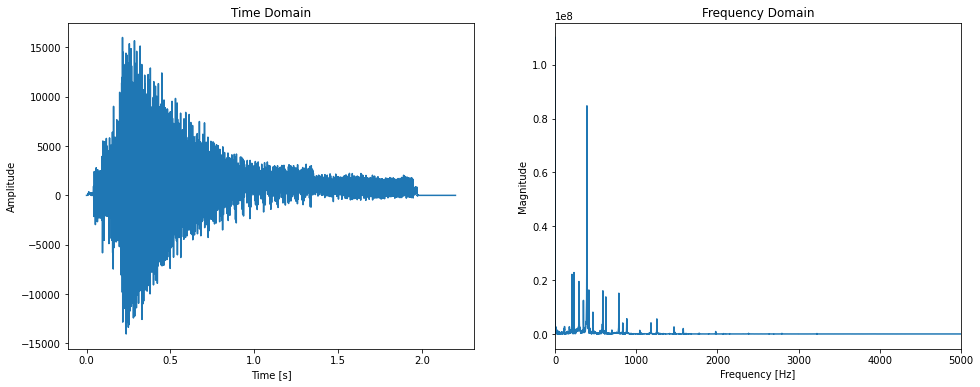

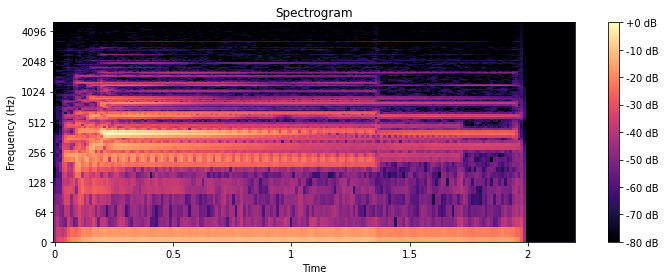

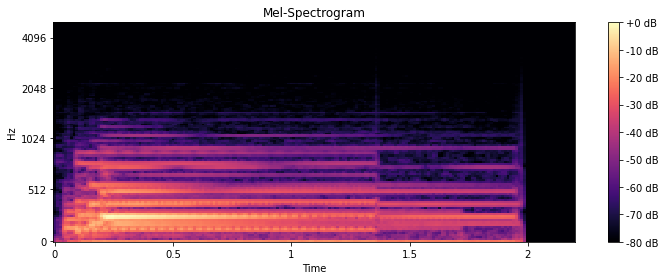

In [8]:
analyzer = AudioAnalyzer(file_data)
file_id = 440 #up to 858

# Play the audio
audio_player = analyzer.play_audio(file_id)
audio_player

# Plot the audio
analyzer.plot_audio(file_id, max_freq=5000)
analyzer.plot_spectrogram(file_id, max_freq=5000)
analyzer.plot_mel_spectrogram(file_id, max_freq=5000)

---

## Data Preparation

The dataset consists of raw .wav files, so no traditional tabular data is available. Preprocessing will involve extracting features like MFCCs, spectrograms, or chroma features to transform the audio into usable data. Challenges include ensuring that these features correctly capture the harmonic information while handling variations in recording quality and instrument type. We estimate several hundred rows of data, each representing an individual chord sample. Visualizations like waveform plots and spectrograms will be used to explore the features that distinguish major from minor chords.

### Extract Features

#### Audio features:

Using the `extract_audio_features` method, we extracted and structured chroma, MFCC, spectral centroid, and zero-crossing rate features. 

We will also ensure these features are properly aligned with the data format needed for the CNN + LSTM model.

#### Harmonics and Intervals

Using the find_harmonics and selected features from our [Feature Engineering] section

#### Encode Labels
Our target feature 'label' should be converted into a numerical format.
> 0: Major 
> 1: Minor

In [9]:
def extract_audio_features(signal=None, sr=22050, hop_length=512, n_fft=2048):
    if signal is None or not isinstance(signal, np.ndarray):
        print("Warning: No valid audio signal provided.")
        return {
            'chroma': np.full(12, np.nan),
            'mfcc': np.full(20, np.nan),
            'spectral_centroid': np.nan,
            'zero_crossing_rate': np.nan
        }

    try:
        chroma = librosa.feature.chroma_stft(y=signal, sr=sr, hop_length=hop_length, n_fft=n_fft).mean(axis=1)
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20, hop_length=hop_length, n_fft=n_fft).mean(axis=1)
        spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, hop_length=hop_length).mean()
        zero_crossing_rate = librosa.feature.zero_crossing_rate(signal, hop_length=hop_length).mean()

        return {
            'chroma': chroma,
            'mfcc': mfccs,
            'spectral_centroid': spectral_centroid,
            'zero_crossing_rate': zero_crossing_rate
        }

    except Exception as e:
        print(f"Error during feature extraction: {e}")
        return {
            'chroma': np.full(12, np.nan),
            'mfcc': np.full(20, np.nan),
            'spectral_centroid': np.nan,
            'zero_crossing_rate': np.nan
        }

In [10]:
def find_harmonics(signal=None, sr=22050, n_fft=2048):
    try:
        if signal is None or len(signal) == 0:
            raise ValueError("No audio signal provided.")

        S = np.abs(librosa.stft(signal, n_fft=n_fft))
        magnitude = np.mean(S, axis=1)
        frequency = np.fft.fftfreq(len(magnitude), 1/sr)
        positive_freq_idxs = np.where(frequency >= 0)
        positive_freqs = frequency[positive_freq_idxs]
        positive_magnitude = magnitude[positive_freq_idxs]

        peaks, _ = find_peaks(positive_magnitude, height=np.max(positive_magnitude) * 0.1)
        harmonic_frequencies = positive_freqs[peaks]
        harmonic_intervals = np.diff(harmonic_frequencies) if len(harmonic_frequencies) > 1 else []

        return harmonic_frequencies, harmonic_intervals

    except Exception as e:
        print(f"Error processing harmonics for augmented signal: {e}")
        return None, None

In [11]:
def extract_mel_spectrogram(signal=None, sr=22050, n_mels=128, hop_length=512, fixed_length=100):
    if signal is None or not isinstance(signal, np.ndarray):
        print("Warning: No valid audio signal provided for mel-spectrogram extraction.")
        return np.full((fixed_length, n_mels), np.nan)

    try:
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, hop_length=hop_length)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        log_mel_spectrogram = log_mel_spectrogram.T

        if log_mel_spectrogram.shape[0] < fixed_length:
            pad_width = fixed_length - log_mel_spectrogram.shape[0]
            log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, pad_width), (0, 0)), mode='constant')
        else:
            log_mel_spectrogram = log_mel_spectrogram[:fixed_length, :]

        return log_mel_spectrogram

    except Exception as e:
        print(f"Error during Mel-spectrogram extraction: {e}")
        return np.full((fixed_length, n_mels), np.nan)

In [12]:
# Define a function to calculate harmonic ratios with feature toggle
def calculate_harmonic_ratios(df, harmonic_prefix='harmonic_', toggle=True):
    if not toggle:  # If toggle is False, skip harmonic ratio calculation
        return df

    harmonic_columns = [col for col in df.columns if harmonic_prefix in col]
    harmonic_ratios = []

    if len(harmonic_columns) > 1:
        for i in range(len(harmonic_columns)):
            for j in range(i + 1, len(harmonic_columns)):
                col_i = harmonic_columns[i]
                col_j = harmonic_columns[j]
                ratio_col_name = f'harmonic_ratio_{i+1}_to_{j+1}'

                harmonic_ratio = df[col_i] / df[col_j]
                harmonic_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)
                harmonic_ratios.append(harmonic_ratio.rename(ratio_col_name))

        ratio_df = pd.concat([df] + harmonic_ratios, axis=1)
        ratio_df.fillna(0, inplace=True)
        return ratio_df
    else:
        print("Not enough harmonic columns in data to compute ratios.")
        return df

#### Running Feature Extraction on Dataset:

In [13]:
def extract_features_from_signals(data, feature_toggles):
    feature_dict_list = []

    for index, row in data.iterrows():
        try:
            signal, sr = librosa.load(row['path'], sr=None)
            feature_dict = {'id': row['id'], 'Label': row['label']}

            # Extract features based on toggles
            if feature_toggles.get('chroma', False):
                feature_dict.update({'chroma': extract_audio_features(signal, sr)['chroma']})
            if feature_toggles.get('mfcc', False):
                feature_dict.update({'mfcc': extract_audio_features(signal, sr)['mfcc']})
            if feature_toggles.get('spectral_centroid', False):
                feature_dict['spectral_centroid'] = extract_audio_features(signal, sr)['spectral_centroid']
            if feature_toggles.get('zero_crossing_rate', False):
                feature_dict['zero_crossing_rate'] = extract_audio_features(signal, sr)['zero_crossing_rate']
            if feature_toggles.get('harmonics', False):
                harmonics, intervals = find_harmonics(signal, sr)
                feature_dict['harmonics'] = harmonics
                feature_dict['intervals'] = intervals
            if feature_toggles.get('mel_spectrogram', False):
                mel_spectrogram = extract_mel_spectrogram(signal, sr)
                feature_dict['mel_spectrogram'] = mel_spectrogram.flatten()

            feature_dict_list.append(feature_dict)

        except Exception as e:
            print(f"Error processing file {row['path']}: {e}")

    return pd.DataFrame(feature_dict_list)


---

## Feature Engineering

Our first couple model iterations used all frequency peaks to train the model, resulting in ~ 65% accuracy. Let's do some exploratory analysis and feature engineering to only pull the frequencies that matter to the note being heard, and not the extra harmonics generated by the instrtument. 

#### Harmonics and Intervals

In [ ]:
print(harmonics_df.columns)

In [ ]:
harmonic_columns = [col for col in harmonics_df.columns if 'harmonic_' in col]
num_harmonics = len(harmonic_columns)

interval_columns = [col for col in harmonics_df.columns if 'interval_' in col]
num_intervals = len(interval_columns)

In [ ]:
# Summary statistics 
harmonic_summary = harmonics_df[harmonic_columns].describe()
print(harmonic_summary)

In [ ]:
# Filter out columns that have zero variance
harmonic_columns_with_variance = [col for col in harmonic_columns if harmonics_df[col].var() > 0]

# Determine the number of columns and rows for plotting
num_cols = 4
num_rows = int(np.ceil(len(harmonic_columns_with_variance) / num_cols))

# Loop through each harmonic and plot the distributions
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()  # Flatten axes for easier iteration

for i, col in enumerate(harmonic_columns_with_variance):
    sns.kdeplot(ax=axes[i], data=harmonics_df, x=col, hue="Label", fill=True)
    axes[i].set_title(col)

# Hide extra subplots if necessary
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


In [ ]:
# Filter out interval columns that have zero variance
interval_columns_with_variance = [col for col in interval_columns if harmonics_df[col].var() > 0]

# Determine the number of columns and rows for plotting
num_cols = 4
num_rows = int(np.ceil(len(interval_columns_with_variance) / num_cols))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()

# Loop through each interval column and plot the distributions
for i, col in enumerate(interval_columns_with_variance):
    sns.kdeplot(ax=axes[i], data=harmonics_df, x=col, hue="Label", fill=True)
    axes[i].set_title(col)

# Hide extra subplots if necessary
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
fig.tight_layout()
plt.show()


In [ ]:
# Define valid_columns to include all harmonic and interval columns
valid_columns = [col for col in harmonics_df.columns if 'harmonic_' in col or 'interval_' in col]

# Ensure only numeric columns are considered for NaN filling
numeric_columns = valid_columns  # valid_columns should only contain numeric data (harmonics + intervals)

# Fill NaN values with the column mean for the numeric columns only
harmonics_df_clean = harmonics_df.copy()  # Work on a copy of the original DataFrame
harmonics_df_clean[numeric_columns] = harmonics_df_clean[numeric_columns].fillna(harmonics_df[numeric_columns].mean())

# Programmatic Correlation Analysis
if not harmonics_df_clean.empty:
    correlations = harmonics_df_clean[numeric_columns].corrwith(harmonics_df_clean['Label'].astype('category').cat.codes)

    # Sort the correlations by absolute value to find the most important features
    sorted_correlations = correlations.abs().sort_values(ascending=False)
    print(sorted_correlations.head(10))  # Top 10 features
else:
    print("No valid data for correlation analysis.")


In [ ]:
# Suppress specific runtime warnings
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")
warnings.filterwarnings("ignore", message="divide by zero encountered in divide")

# Check if columns have no variance (either zero or NaN-filled) and remove them
valid_harmonic_columns = [col for col in harmonic_columns if harmonics_df[col].nunique() > 1]
valid_interval_columns = [col for col in interval_columns if harmonics_df[col].nunique() > 1]

# Combine valid columns for correlation analysis
valid_columns = valid_harmonic_columns + valid_interval_columns

# Fill NaN values with 0 to avoid issues in correlation (alternative: you could drop NaNs)
harmonics_df_clean = harmonics_df[valid_columns + ['Label']].fillna(0)

# Programmatic Correlation Analysis
if not harmonics_df_clean.empty:
    correlations = harmonics_df_clean[valid_columns].corrwith(harmonics_df_clean['Label'].astype('category').cat.codes)

    # Sort the correlations by absolute value to find the most important features
    sorted_correlations = correlations.abs().sort_values(ascending=False)
    print(sorted_correlations.head(10))  # Top 10 features
else:
    print("No valid data for correlation analysis.")

`outdated`
#### Manual Inspection:

##### Harmonics:

Visually inspecting the plots for Harmonics and Intervals that might be more helpful in our model to distinguish chords, these are the harmonics with LESS overlay in Major / Minor chords (though, not by much!):

- harmonic_20
- harmonic_26
- harmonic_30

##### Intervals:
- interval_1
- interval_2
- interval_3
- interval_4
- interval_19
- interval_25
- interval_30

Other Notes:
- Interval 28 and 5 seem to have a similar shape, but different densities. Though, there is a small bit of non-overlap. This also applies for harmonic_26
- Interval 31 and 32 are both only charts with 'Major', meaning the 'Minor' data is either extremely small, or non-existant (likely the latter). I'm not sure whether we should use these quite yet. 

### Combined Analysis for Feature Engineering:

With our manual inspection and programatic correlation analysis, here is a final list of features:

- harmonic_20: Appears in both visual and correlation analysis.
- harmonic_26: Identified visually.
- harmonic_30: Strong in both visual and correlation analysis.
- harmonic_31: High correlation but not identified visually (worth testing).

##### Intervals:

- Interval 2, 3, 4, 19, 25: Visually identified
- Interval 30: Strong in both visual and correlation analysis.
- 
    Interval 27
    Interval 31: High correlation, but missing Minor data (requires further scrutiny).


In [ ]:
selected_harmonic_features = [ 'id',
    'harmonic_20', 'harmonic_26', 'harmonic_30', 'harmonic_31',
    'interval_1', 'interval_2', 'interval_3', 'interval_4', 'interval_19', 
    'interval_25', 'interval_30', 'interval_27', 'interval_31'
]

## Ratios Between Specific Harmonics

While harmonic frequencies and intervals between them are useful, the way they relate to major vs minor chords could be more nuanced than just the interval values (like we are using). Major and minor chords differ mainly in the 3rd interval (major third vs minor third). We will focus on specific intervals or harmonic relationships that are known to differentiate major and minor chords.

We will compute the ratio between the 1st harmonic and the 3rd harmonic for each chord - and use that as a new feature. 

In [ ]:
# List to hold the new harmonic ratio columns and their data
harmonic_ratio_data = []

# Get harmonic columns
harmonic_columns = [col for col in harmonics_df.columns if 'harmonic_' in col]

# Ensure there are at least 2 harmonic columns to calculate ratios
if len(harmonic_columns) > 1:
    for i in range(len(harmonic_columns)):
        for j in range(i + 1, len(harmonic_columns)):
            col_i = harmonic_columns[i]
            col_j = harmonic_columns[j]
            ratio_col_name = f'harmonic_ratio_{i}_to_{j}'  # Ensure "harmonic_ratio" is in the name
            
            # Calculate the ratio, avoiding division by zero
            harmonic_ratio = harmonics_df[col_i] / harmonics_df[col_j]
            harmonic_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
            
            # Append the calculated ratios and column name to the list
            harmonic_ratio_data.append(harmonic_ratio.rename(ratio_col_name))
    
    # Concatenate all harmonic ratio columns at once to the DataFrame
    harmonic_ratio_df = pd.concat([harmonics_df] + harmonic_ratio_data, axis=1)

    # Fill NaN values with 0 or another appropriate value (depending on your analysis)
    harmonic_ratio_df.fillna(0, inplace=True)
    
    # Display the new DataFrame
    print(harmonic_ratio_df.head())
else:
    print("Not enough harmonic columns to compute ratios.")


In [ ]:
# Check for non-zero variance columns before plotting
harmonic_ratio_columns = [col for col in harmonic_ratio_df.columns if 'harmonic_ratio' in col]
non_zero_variance_columns = [col for col in harmonic_ratio_columns if harmonic_ratio_df[col].var() > 0]

if non_zero_variance_columns:
    # Set up a grid for plotting
    num_cols = 4
    num_rows = int(np.ceil(len(non_zero_variance_columns) / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()

    # Loop through each harmonic ratio column and plot the distribution
    for i, col in enumerate(non_zero_variance_columns):
        sns.kdeplot(ax=axes[i], data=harmonic_ratio_df, x=col, hue="Label", fill=True)
        axes[i].set_title(col)

    # Adjust layout and remove any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()
else:
    print("No non-zero variance harmonic ratios to plot.")


In [ ]:
# Check how many harmonic ratio columns are left
print(f"Number of harmonic ratio columns: {len(harmonic_ratio_columns)}")
print(harmonic_ratio_df[harmonic_ratio_columns].describe())


In [ ]:
# Ensure harmonic ratio columns are included (for ratio columns only)
harmonic_ratio_columns_cleaned = [col for col in harmonic_ratio_df.columns if 'harmonic_ratio' in col]

# Exclude ratios involving harmonics 18, 19, or 20, as they only have Major data
harmonic_ratio_columns_filtered = [col for col in harmonic_ratio_columns_cleaned if not any(x in col for x in ['_18', '_19', '_20'])]

# Perform the correlation analysis for the filtered harmonic ratio columns only
if harmonic_ratio_columns_filtered:
    # Clean the DataFrame by removing any NaNs or infinities before running correlations
    harmonic_ratio_df_cleaned = harmonic_ratio_df[harmonic_ratio_columns_filtered + ['Label']].copy()

    # Convert 'Label' column to category codes (numeric)
    harmonic_ratio_df_cleaned['Label'] = harmonic_ratio_df_cleaned['Label'].astype('category').cat.codes

    # Fill NaN values with the column mean for numeric columns only
    harmonic_ratio_df_cleaned[harmonic_ratio_columns_filtered] = harmonic_ratio_df_cleaned[harmonic_ratio_columns_filtered].fillna(
        harmonic_ratio_df_cleaned[harmonic_ratio_columns_filtered].mean())

    # Calculate the correlations
    correlations = harmonic_ratio_df_cleaned[harmonic_ratio_columns_filtered].corrwith(harmonic_ratio_df_cleaned['Label'])

    # Sort the correlations by absolute value to find the most important ratio features
    sorted_correlations = correlations.abs().sort_values(ascending=False)

    # Display the top 10 most correlated harmonic ratios
    print("Top 20 most correlated harmonic ratios (excluding harmonics 18, 19, 20):")
    print(sorted_correlations.head(20))
else:
    print("No harmonic ratio columns found.")


In [ ]:
# Exclude ratios involving harmonics 17, 18, 19, or 20
harmonic_ratio_columns_filtered_no_17 = [col for col in harmonic_ratio_columns_cleaned if not any(x in col for x in ['_17', '_18', '_19', '_20'])]

# Perform the correlation analysis for the filtered harmonic ratio columns only
if harmonic_ratio_columns_filtered_no_17:
    # Clean the DataFrame by removing any NaNs or infinities before running correlations
    harmonic_ratio_df_cleaned_no_17 = harmonic_ratio_df[harmonic_ratio_columns_filtered_no_17 + ['Label']].copy()

    # Convert 'Label' column to category codes (numeric)
    harmonic_ratio_df_cleaned_no_17['Label'] = harmonic_ratio_df_cleaned_no_17['Label'].astype('category').cat.codes

    # Fill NaN values with the column mean for numeric columns only
    harmonic_ratio_df_cleaned_no_17[harmonic_ratio_columns_filtered_no_17] = harmonic_ratio_df_cleaned_no_17[harmonic_ratio_columns_filtered_no_17].fillna(
        harmonic_ratio_df_cleaned_no_17[harmonic_ratio_columns_filtered_no_17].mean())

    # Calculate the correlations
    correlations_no_17 = harmonic_ratio_df_cleaned_no_17[harmonic_ratio_columns_filtered_no_17].corrwith(harmonic_ratio_df_cleaned_no_17['Label'])

    # Sort the correlations by absolute value to find the most important ratio features
    sorted_correlations_no_17 = correlations_no_17.abs().sort_values(ascending=False)

    # Display the top 10 most correlated harmonic ratios (excluding harmonics 17, 18, 19, 20)
    print("Top 10 most correlated harmonic ratios (excluding harmonics 17, 18, 19, 20):")
    print(sorted_correlations_no_17.head(10))
else:
    print("No harmonic ratio columns found.")


In [ ]:
# a bit odd that all highly correlated harmonics include 17, and not 1 / 3 like I had predicted. 

# Check Harmonic 1/3 ratio and inspect the data for major and minor labels

# Calculate harmonic ratio 1/3
harmonic_ratio_1_3 = harmonic_ratio_df['harmonic_1'] / harmonic_ratio_df['harmonic_3']

# Add the harmonic ratio to the DataFrame if not already added
if 'harmonic_ratio_1_3' not in harmonic_ratio_df.columns:
    harmonic_ratio_df['harmonic_ratio_1_3'] = harmonic_ratio_1_3

# Summary statistics for Harmonic 1/3 ratio for both major and minor chords
print("Summary statistics for Harmonic Ratio 1/3 (Major vs Minor):")
print(harmonic_ratio_df.groupby('Label')['harmonic_ratio_1_3'].describe())

# Visualize the distribution of Harmonic Ratio 1/3 for both labels
plt.figure(figsize=(10, 6))
sns.kdeplot(data=harmonic_ratio_df, x='harmonic_ratio_1_3', hue='Label', fill=True)
plt.title("Distribution of Harmonic Ratio 1/3 (Major vs Minor)")
plt.xlabel("Harmonic Ratio 1/3")
plt.ylabel("Density")
plt.show()

In [ ]:
# Exclude ratios involving harmonics 17, 18, 19, or 20 - potentially more generalizable
harmonic_ratio_columns_filtered_no_17_18_19_20 = [
    col for col in harmonic_ratio_columns_cleaned if not any(x in col for x in ['_17', '_18', '_19', '_20'])
]

# Perform the correlation analysis for the filtered harmonic ratio columns only
if harmonic_ratio_columns_filtered_no_17_18_19_20:
    # Clean the DataFrame by removing any NaNs or infinities before running correlations
    harmonic_ratio_df_cleaned_no_17_18_19_20 = harmonic_ratio_df[harmonic_ratio_columns_filtered_no_17_18_19_20 + ['Label']].copy()

    # Convert 'Label' column to category codes (numeric)
    harmonic_ratio_df_cleaned_no_17_18_19_20['Label'] = harmonic_ratio_df_cleaned_no_17_18_19_20['Label'].astype('category').cat.codes

    # Fill NaN values with the column mean for numeric columns only
    harmonic_ratio_df_cleaned_no_17_18_19_20[harmonic_ratio_columns_filtered_no_17_18_19_20] = harmonic_ratio_df_cleaned_no_17_18_19_20[harmonic_ratio_columns_filtered_no_17_18_19_20].fillna(
        harmonic_ratio_df_cleaned_no_17_18_19_20[harmonic_ratio_columns_filtered_no_17_18_19_20].mean())

    # Calculate the correlations
    correlations_no_17_18_19_20 = harmonic_ratio_df_cleaned_no_17_18_19_20[harmonic_ratio_columns_filtered_no_17_18_19_20].corrwith(harmonic_ratio_df_cleaned_no_17_18_19_20['Label'])

    # Sort the correlations by absolute value to find the most important ratio features
    sorted_correlations_no_17_18_19_20 = correlations_no_17_18_19_20.abs().sort_values(ascending=False)

    # Display the top 10 most correlated harmonic ratios (excluding harmonics 17, 18, 19, 20)
    print("Top 10 most correlated harmonic ratios (excluding harmonics 17, 18, 19, 20):")
    print(sorted_correlations_no_17_18_19_20.head(10))
else:
    print("No harmonic ratio columns found.")


In [ ]:
# we will focus on the correlations for harmonics not involving 17 and higher - for a more generalizable model
# but we will include a couple of the top harmonic ratios involving 17 to see if they improve model performance

selected_harmonic_ratios = [ 'harmonic_ratio_2_to_3', 'harmonic_ratio_0_to_13', 
                            'harmonic_ratio_6_to_13', 'harmonic_ratio_3_to_13', 
                            'harmonic_ratio_4_to_13', 'harmonic_ratio_2_to_13', 
                            'harmonic_ratio_8_to_13', 'harmonic_ratio_7_to_13',
                            'harmonic_ratio_5_to_13', 'harmonic_ratio_6_to_7'
                           ]

## Finalizing Data before Modeling

- feature toggling because I can't pick favorites
- 

In [16]:
# Feature Toggles
feature_toggles = {
    'chroma': True,
    'mfcc': True,
    'spectral_centroid': True,
    'zero_crossing_rate': True,
    'harmonics': True,
    'mel_spectrogram': True
}

# Extract Features for All Data
raw_combined_df = extract_features_from_signals(file_data, feature_toggles)

# Display Resulting DataFrame
print("Extracted Features DataFrame:")
print(raw_combined_df.head())


<ipython-input-13-102635bb6403>:6: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(row['path'], sr=None)


Error processing file C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_285.wav: 
Extracted Features DataFrame:
              id  Label                                             chroma  \
0    Major_0.wav  Major  [0.7968521, 0.41725653, 0.2998105, 0.39145, 0....   
1    Major_1.wav  Major  [0.7232829, 0.45263815, 0.26252756, 0.23647432...   
2   Major_10.wav  Major  [0.37183326, 0.2676605, 0.1256456, 0.14466327,...   
3  Major_100.wav  Major  [0.39077398, 0.9342459, 0.7632381, 0.55300677,...   
4  Major_101.wav  Major  [0.20732851, 0.4035183, 0.40069222, 0.4611866,...   

                                                mfcc  spectral_centroid  \
0  [-338.3117, 257.16064, 37.91532, -19.911049, 0...         731.644753   
1  [-404.3833, 179.5291, 68.798615, 6.5934095, -3...         497.091980   
2  [-355.2513, 251.06386, 58.341755, -14.42813, -...         608.686444   
3  [-336.5666, 255.45099, 25.056515, -28.689547, ...         735.732537   
4  [-390.57816, 17

In [17]:
# Validation Step: Count Zero and Non-Zero Values for Raw Data
print("Validation of Feature Counts in raw_combined_df:")

for column in raw_combined_df.columns:
    # For numeric scalar columns
    if pd.api.types.is_numeric_dtype(raw_combined_df[column]):
        zero_count = (raw_combined_df[column] == 0).sum()
        non_zero_count = (raw_combined_df[column] != 0).sum()

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

    # For list/array columns
    else:
        zero_count, non_zero_count = 0, 0
        for value in raw_combined_df[column]:
            if isinstance(value, (list, np.ndarray)):
                value_array = np.array(value)
                zero_count += np.sum(value_array == 0)
                non_zero_count += np.sum(value_array != 0)

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")


Validation of Feature Counts in raw_combined_df:
Feature 'mel_spectrogram':
  Zero Count: 571
  Non-Zero Count: 10981829



---

## Augmenting Data
womp womp

We will augment the audio data using techniques such as time-stretching, pitch-shifting, and adding noise. The augmented data will then have features extracted in the same way as the original data. We will apply these augmentations to our data to create synthetic data - to even the distribution of our classes.



In [18]:
# Augmentation functions
def pitch_shift(signal, sr, n_steps=4):
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=n_steps)

def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal))
    return signal + noise_factor * noise

def augment_audio(signal, sr):
    augmentations = ['time_stretch', 'pitch_shift', 'add_noise']
    augmentation = random.choice(augmentations)

    if augmentation == 'time_stretch':
        return librosa.effects.time_stretch(signal, rate=1.2)
    elif augmentation == 'pitch_shift':
        return pitch_shift(signal, sr, n_steps=4)
    elif augmentation == 'add_noise':
        return add_noise(signal)
    else:
        return signal

In [19]:
# Count existing samples in the original dataset
original_counts = file_data['label'].value_counts()
target_count = 500

# Determine how many samples to augment for each class
augmented_counts = {label: target_count - count if count < target_count else 0 for label, count in original_counts.items()}


In [20]:
# Augmentation and Feature Extraction Workflow for Augmented Data
def augment_and_extract_features(data, target_count, feature_toggles):
    augmented_data = []
    augmentation_tracker = {label: 0 for label in data['label'].unique()}

    for index, row in data.iterrows():
        try:
            # Skip if augmentation target already met for the class
            if augmentation_tracker[row['label']] >= target_count:
                continue

            # Load the original audio signal
            signal, sr = librosa.load(row['path'], sr=None)
            if signal is None or len(signal) == 0:
                print(f"Warning: Empty or invalid audio signal for {row['path']}")
                continue

            # Apply augmentation
            augmented_signal = augment_audio(signal, sr)
            if augmented_signal is None or not isinstance(augmented_signal, np.ndarray):
                print(f"Warning: Augmented signal is not valid for {row['path']}")
                continue

            # Extract features from the augmented signal
            features = extract_audio_features(augmented_signal, sr=sr)
            harmonics, intervals = find_harmonics(augmented_signal, sr=sr)
            mel_spectrogram = extract_mel_spectrogram(augmented_signal, sr=sr)

            # Prepare feature dictionary for augmented data
            feature_dict = {
                'id': row['id'].replace('.wav', '') + '_aug',
                'Label': row['label']
            }

            # Add features as lists, similar to raw_combined_df
            if feature_toggles['chroma']:
                feature_dict['chroma'] = features['chroma']

            if feature_toggles['mfcc']:
                feature_dict['mfcc'] = features['mfcc']

            if feature_toggles['spectral_centroid']:
                feature_dict['spectral_centroid'] = features['spectral_centroid']

            if feature_toggles['zero_crossing_rate']:
                feature_dict['zero_crossing_rate'] = features['zero_crossing_rate']

            if feature_toggles['harmonics']:
                feature_dict['harmonics'] = harmonics
                feature_dict['intervals'] = intervals

            if feature_toggles['mel_spectrogram']:
                feature_dict['mel_spectrogram'] = mel_spectrogram

            # Append to augmented data
            augmented_data.append(feature_dict)

            # Increment the augmentation count for the class
            augmentation_tracker[row['label']] += 1

        except Exception as e:
            print(f"Error augmenting and extracting features from {row['path']}: {e}")

    return pd.DataFrame(augmented_data)

In [21]:
# Feature Toggles for Augmented Data
feature_toggles = {
    'chroma': True,
    'mfcc': True,
    'spectral_centroid': True,
    'zero_crossing_rate': True,
    'harmonics': True,
    'mel_spectrogram': True
}

# Target Count for Augmentation
target_count = 500

# Extract Features for Augmented Data
augmented_combined_df = augment_and_extract_features(file_data, target_count, feature_toggles)

# Replace NaN values with 0 in augmented_combined_df
augmented_combined_df.fillna(0, inplace=True)

# Display Resulting DataFrame
print("Extracted Features DataFrame (Augmented Data):")
print(augmented_combined_df.head())

<ipython-input-20-1d57bb54db89>:13: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(row['path'], sr=None)


Error augmenting and extracting features from C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_285.wav: 
Extracted Features DataFrame (Augmented Data):
              id  Label                                             chroma  \
0    Major_0_aug  Major  [0.2003257, 0.04176243, 0.10400773, 0.4357231,...   
1    Major_1_aug  Major  [0.38977775, 0.15225103, 0.14260349, 0.5150566...   
2   Major_10_aug  Major  [0.44684538, 0.34706673, 0.17956433, 0.1954171...   
3  Major_100_aug  Major  [0.33962563, 0.14328004, 0.2900532, 0.11750816...   
4  Major_101_aug  Major  [0.2901788634983697, 0.5214080145769969, 0.521...   

                                                mfcc  spectral_centroid  \
0  [-340.94836, 235.97925, 23.977484, -17.400124,...         817.822688   
1  [-441.7959, 188.3225, 46.277046, -4.4026017, -...         629.005761   
2  [-374.24863, 245.74521, 63.74927, -11.417588, ...         594.663801   
3  [-341.47174, 247.10913, 2.9444284, -35.3721, -...

In [22]:
# Validation Step: Count Zero and Non-Zero Values for Augmented Data
print("Validation of Feature Counts in augmented_combined_df:")

for column in augmented_combined_df.columns:
    # For numeric scalar columns
    if pd.api.types.is_numeric_dtype(augmented_combined_df[column]):
        zero_count = (augmented_combined_df[column] == 0).sum()
        non_zero_count = (augmented_combined_df[column] != 0).sum()

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

    # For list/array columns
    else:
        zero_count, non_zero_count = 0, 0
        for value in augmented_combined_df[column]:
            if isinstance(value, (list, np.ndarray)):
                value_array = np.array(value)
                zero_count += np.sum(value_array == 0)
                non_zero_count += np.sum(value_array != 0)

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")


Validation of Feature Counts in augmented_combined_df:
Feature 'mel_spectrogram':
  Zero Count: 677
  Non-Zero Count: 10968923



In [ ]:
---

In [ ]:
# Verify columns to avoid headaches later

# Display the columns of raw_complete_df
print("Columns in raw_complete_df:")
for col in raw_complete_df.columns:
    print(col)

# Separator for better readability
print("\n" + "="*50 + "\n")

# Display the columns of augmented_complete_df
print("Columns in augmented_complete_df:")
for col in augmented_complete_df.columns:
    print(col)


---

# Modeling

This is a classification problem, with the goal of predicting whether a chord is major or minor. The initial plan is to use a basic model like logistic regression or SVM as a baseline. After extracting features like MFCCs or spectrograms, we will establish the baseline and then experiment with more advanced models like convolutional neural networks (CNNs) to improve accuracy.

### Model Iterations:

#### Model v1:

First, I wanted to to compare the extract_features method I used in my [last project]() (mostly out of curiosity :p)

This included extracting features like:
- **Chroma Features**: calculated using the short-time Fourier transform (STFT) of the audio file. Chroma features capture the essence of the pitch content within each octave group - which is vital for chord identification.
- **MFCCs**: used to capture the timbral aspects of an audio signal. (This is what makes a song or chord 'feel' a certain way!) The first few coefficients especially provide a good representation of the overall spectral shape which is influenced by the harmonic structure of the chord.

These features were fed into a Convolutional Neural Network (CNN):

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| Major | 0.53      | 1.00   | 0.70     | 46      |
| Minor | 0.00      | 0.00   | 0.00     | 40      |
| **accuracy** | | | 0.53 | 86 |
| **macro avg** | 0.27 | 0.50 | 0.35 | 86 |
| **weighted avg** | 0.29 | 0.53 | 0.37 | 86 |

This is alarming - our scores for precision, recall, and f1-score for the Minor class are ALL zero. 
This is probably because we are focusing in on timbral aspects of the audio, rather than the individual frequencies of the notes in the chords. But an interesting first model!


#### Model v2:

After implementing a new feature extraction method to (instead) extract harmonics, these are the results of a simple Logistic Regression as a baseline classifier.

Accuracy: 60.47%

Classification Report (Harmonics & Simple Logistic Regression):

|               | precision | recall | f1-score | support |
|---------------|------------|--------|----------|---------|
| **Major**     | 0.63       | 0.81   | 0.71     | 101     |
| **Minor**     | 0.54       | 0.31   | 0.39     | 71      |
| **accuracy**  |            |        | **0.60**     | 172     |
| **macro avg** | 0.58       | 0.56   | 0.55     | 172     |
| **weighted avg** | 0.59    | 0.60   | 0.58     | 172     |

Confusion Matrix:

[[82 19]

 [49 22]]
 
 
  Lets try a more advanced models:
 
 #### Model v3:
 
Support Vector Machine (SVM): 58.14%
              precision    recall  f1-score   support

       Major       0.60      0.83      0.70       101
       Minor       0.48      0.23      0.31        71

    accuracy                           **0.58**       172
   macro avg       0.54      0.53      0.50       172
weighted avg       0.56      0.58      0.54       172

[[84 17]

 [55 16]]

#### Model v4:

Random Forest Accuracy: 69.19%
              precision    recall  f1-score   support

       Major       0.76      0.70      0.73       101
       Minor       0.62      0.68      0.64        71

    accuracy                           **0.69**       172
   macro avg       0.69      0.69      0.69       172
weighted avg       0.70      0.69      0.69       172

[[71 30]

 [23 48]]
 
 
#### Model v5:

Neural Network Accuracy: 62.79%
              precision    recall  f1-score   support

       Major       0.63      0.89      0.74       101
       Minor       0.62      0.25      0.36        71

    accuracy                           **0.63**       172
   macro avg       0.63      0.57      0.55       172
weighted avg       0.63      0.63      0.58       172

Confusion Matrix for Neural Network:

[[90 11]

 [53 18]]
 
#### Model v6:

Now, using feature engineering to only train with features that will be useful for the model!

Random Tree (with feature engineering):
              precision    recall  f1-score   support

       Major       0.82      0.91      0.86        98
       Minor       0.86      0.73      0.79        74

    accuracy                           **0.83**       172
   macro avg       0.84      0.82      0.82       172
weighted avg       0.83      0.83      0.83       172

Confusion Matrix:

[[89  9]

[20 54]]


#### Model v7:

A lot of audio classification will rely on the MFCCS ( explain later lol ), so I also wanted to attempt combining my original model's method of extracting features with the previous model's feature engineering of the harmonics method. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.74      0.92      0.82        98
       Minor       0.84      0.58      0.69        74

    accuracy                           **0.77**       172
   macro avg       0.79      0.75      0.75       172
weighted avg       0.79      0.77      0.76       172

Confusion Matrix:
[[90  8]
 [31 43]]


#### Model v8:

Neural Network for the same group of features. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.71      0.82      0.76        98
       Minor       0.69      0.55      0.62        74

    accuracy                           **0.70**       172
   macro avg       0.70      0.69      0.69       172
weighted avg       0.70      0.70      0.70       172

Confusion Matrix:

[[80 18]

 [33 41]]
 
#### Model v9:

While harmonic frequencies and intervals between them are useful, the way they relate to major vs minor chords could be more nuanced than just the interval values (like we are using). Major and minor chords differ mainly in the 3rd interval (major third vs minor third). We will focus on specific intervals or harmonic relationships that are known to differentiate major and minor chords.

We will compute the ratio between the 1st harmonic and the 3rd harmonic for each chord - and use that as a new feature. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.77      0.81      0.79        97
       Minor       0.74      0.69      0.72        75

    accuracy                           **0.76**       172
   macro avg       0.76      0.75      0.76       172
weighted avg       0.76      0.76      0.76       172

Confusion Matrix:

[[79 18]

 [23 52]]


#### Model v10: CNN + LSTM

We will generate Mel-Spectograms instead of using a regular spectogram (from librosa.stft), because Mel-spectograms more closely match human perception of sound frequencies. 

Classification Report for Optimized Model:
              precision    recall  f1-score   support

       Major       0.58      1.00      0.74       100
       Minor       0.00      0.00      0.00        72

    accuracy                           **0.58**       172
   macro avg       0.29      0.50      0.37       172
weighted avg       0.34      0.58      0.43       172

Confusion Matrix for Optimized Model:
[[100   0]
 [ 72   0]]
 
Very upsetting that the model only votes for major - we've been seeing this a lot in recent attempts. I'm biting the bullet and giving into data augmentation, but audio can be ~~extremely (':~~ annoying to work with.
 
 #### Model v11: even class distribution
 
 I cleaned up the combining of features to make it easier for me to try different models. This was our first successful model using the augmented data: a CNN + LSTM Model like Model v10, but with ((slightly)) better results.
 
Classification Report:
              precision    recall  f1-score   support

       Major       0.54      1.00      0.70       101
       Minor       1.00      0.13      0.23       100

    accuracy                           **0.57**       201
   macro avg       0.77      0.56      0.46       201
weighted avg       0.77      0.57      0.47       201

Confusion Matrix:
[[101   0]
 [ 87  13]]

In [ ]:
# Merge features_df, harmonics_df, mel_df, and harmonic_ratio_df
raw_complete_df = features_df.merge(harmonics_df, on=['id', 'Label'], how='left')
raw_complete_df = raw_complete_df.merge(mel_df, on=['id', 'Label'], how='left')
raw_complete_df = raw_complete_df.merge(harmonic_ratio_df, on=['id', 'Label'], how='left')

# Display the DataFrame to verify
print("Raw Complete DataFrame (with all possible features):")
print(raw_complete_df.head())


In [ ]:
# Merge augmented_features_df and augmented_harmonic_ratio_df
augmented_complete_df = augmented_features_df.merge(augmented_harmonic_ratio_df, on=['id', 'Label'], how='left')

# Remove the '_x' suffix from the chroma and other feature columns by renaming them
augmented_complete_df.columns = augmented_complete_df.columns.str.replace('_x', '')

# Display the cleaned DataFrame
print("augmented_complete_df (cleaned, with all possible features):")
print(augmented_complete_df.head())


### Data Prep before Modeling:

Combining Different Features to tune the modeling, all done in one spot. (please)

In [ ]:
# Step 1: Train-Test Split Before Augmentation
# Split the raw data into training and testing datasets.
train_df, test_df = train_test_split(raw_features_df, test_size=0.2, random_state=42, stratify=raw_features_df['Label'])

# Separate features and labels for training and testing datasets
X_train = train_df.drop(columns=['id', 'Label'])
y_train = train_df['Label']

X_test = test_df.drop(columns=['id', 'Label'])
y_test = test_df['Label']

In [ ]:
# Step 2: Data Augmentation (Performed only on Training Data)
# Here you augment only X_train to avoid leaking information from test data.
augmented_data = []

for index, row in train_df.iterrows():
    # Apply each augmentation technique to the row (audio data), for example:
    augmented_signals = apply_augmentation(row)  # Assuming apply_augmentation() returns a list of augmented signals
    for signal in augmented_signals:
        features = extract_features(signal)  # Extract features from each augmented signal
        features['id'] = f"{row['id']}_aug"
        features['Label'] = row['Label']
        augmented_data.append(features)

# Create DataFrame for augmented data
augmented_df = pd.DataFrame(augmented_data)

In [ ]:
# Step 3: Combine Original and Augmented Training Data
# Merge the original training data with augmented data
train_complete_df = pd.concat([train_df, augmented_df], ignore_index=True)

# Step 4: Prepare Features and Labels for Final Training
X_train_complete = train_complete_df.drop(columns=['id', 'Label'])
y_train_complete = train_complete_df['Label']

# The test set remains unchanged and was never exposed to augmentation
X_test = test_df.drop(columns=['id', 'Label'])
y_test = test_df['Label']

---

In [ ]:
# Select features for training and testing
def select_features(dataframe, include_groups=None, exclude_groups=None):
    """
    Function to select features based on the groups to include or exclude.

    Parameters:
    - dataframe: The DataFrame containing all features.
    - include_groups: List of feature groups to include. If None, all groups are included.
    - exclude_groups: List of feature groups to exclude. If None, no groups are excluded.

    Returns:
    - A DataFrame containing the selected features.
    """
    feature_groups = {
        'chroma': [f'chroma_{i+1}' for i in range(12)],
        'mfcc': [f'mfcc_{i+1}' for i in range(20)],
        'spectral': ['spectral_centroid'],
        'zero_crossing': ['zero_crossing_rate'],
        'harmonics': ['harmonic_20', 'harmonic_26', 'harmonic_30', 'harmonic_31'],
        'intervals': ['interval_1', 'interval_2', 'interval_3', 'interval_4', 'interval_19', 'interval_25', 'interval_30', 'interval_27', 'interval_31'],
        'harmonic_ratios': ['harmonic_ratio_2_to_3', 'harmonic_ratio_0_to_13', 'harmonic_ratio_6_to_13', 'harmonic_ratio_3_to_13', 
                            'harmonic_ratio_4_to_13', 'harmonic_ratio_2_to_13', 'harmonic_ratio_8_to_13', 'harmonic_ratio_7_to_13', 
                            'harmonic_ratio_5_to_13', 'harmonic_ratio_6_to_7'],
        'mel_spectrogram': [col for col in dataframe.columns if 'mel_spectrogram' in col]  # Include columns with 'mel_spectrogram'
    }
    
    # If no specific groups are provided, include all groups
    if include_groups is None:
        include_groups = list(feature_groups.keys())
    
    # If exclude_groups are provided, remove them from the include_groups
    if exclude_groups:
        include_groups = [group for group in include_groups if group not in exclude_groups]
    
    # Collect all selected feature columns
    selected_features = ['id', 'Label']  # Always include 'id' and 'Label'
    for group in include_groups:
        selected_features.extend(feature_groups[group])
    
    # Filter the DataFrame to only the selected features
    selected_feature_df = dataframe.loc[:, dataframe.columns.intersection(selected_features)]
    return selected_feature_df

In [ ]:
train_features_df = select_features(train_complete_df, include_groups=include_groups)
test_features_df = select_features(test_complete_df, include_groups=include_groups)

# Ensure 'mel_spectrogram' exists in the DataFrame
if 'mel_spectrogram' not in train_features_df.columns or 'mel_spectrogram' not in test_features_df.columns:
    print("'mel_spectrogram' not found in the selected features. Proceeding without mel_spectrogram.")
else:
    print("'mel_spectrogram' successfully found in the selected features.")

# Step 5: Data preparation for model input
X_train = []
y_train = []
X_test = []
y_test = []
n_mels = 128  # Number of Mel bands
fixed_length = 100  # Number of time steps

### CNN + LSTM Model:

- Mel-spectrograms are used as input features.
- CNN processes the Mel-spectrogram images.
- LSTM captures temporal dependencies after CNN processing.

In [ ]:
# Function to pad or truncate Mel-Spectrogram
def pad_or_truncate(mel_spectrogram, fixed_length, n_mels):
    if mel_spectrogram.ndim != 2:
        raise ValueError(f"Expected a 2D array for mel_spectrogram, but got {mel_spectrogram.ndim}D array.")

    # Ensure the spectrogram has the correct shape (n_mels, time_steps)
    if mel_spectrogram.shape[1] == n_mels:  # If it's (time_steps, n_mels), transpose it
        mel_spectrogram = mel_spectrogram.T

    # Now check if the number of mel bands matches
    if mel_spectrogram.shape[0] != n_mels:
        raise ValueError(f"Expected {n_mels} Mel bands, but got {mel_spectrogram.shape[0]}")
    
    # Pad or truncate to fixed_length
    if mel_spectrogram.shape[1] > fixed_length:
        return mel_spectrogram[:, :fixed_length]
    else:
        padding = fixed_length - mel_spectrogram.shape[1]
        return np.pad(mel_spectrogram, ((0, 0), (0, padding)), mode='constant')



In [ ]:
# Prepare training data
for i, row in train_features_df.iterrows():
    mel_spectrogram = row['mel_spectrogram']
    if isinstance(mel_spectrogram, np.ndarray):
        mel_spectrogram_padded = pad_or_truncate(mel_spectrogram, fixed_length, n_mels)
        mel_spectrogram_reshaped = mel_spectrogram_padded[..., np.newaxis]  # Shape: (n_mels, fixed_length, 1)
        X_train.append(mel_spectrogram_reshaped)
        y_train.append(row['Label'])  # Assuming binary labels: 'Major' or 'Minor'

# Prepare testing data
for i, row in test_features_df.iterrows():
    mel_spectrogram = row['mel_spectrogram']
    if isinstance(mel_spectrogram, np.ndarray):
        mel_spectrogram_padded = pad_or_truncate(mel_spectrogram, fixed_length, n_mels)
        mel_spectrogram_reshaped = mel_spectrogram_padded[..., np.newaxis]  # Shape: (n_mels, fixed_length, 1)
        X_test.append(mel_spectrogram_reshaped)
        y_test.append(row['Label'])  # Assuming binary labels: 'Major' or 'Minor'

# Convert lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Print the shape to verify correctness
print(f"Shape of X_train: {X_train.shape}")  # Should be (samples, n_mels, fixed_length, 1)
print(f"Shape of X_test: {X_test.shape}")

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(y)  # Convert labels to binary form (e.g., 0 and 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Ensure input shape is (batch_size, n_mels, fixed_length, 1)
X_train = X_train.reshape((X_train.shape[0], n_mels, fixed_length, 1))
X_test = X_test.reshape((X_test.shape[0], n_mels, fixed_length, 1))

# Normalization of Mel-Spectrograms
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# Check total number of elements
expected_total_elements = X_train.shape[0] * fixed_length * n_mels * 1
print(f"Expected total elements: {expected_total_elements}")
print(f"Actual number of elements in X_train: {X_train.size}")

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
print("Train set distribution:", np.bincount(y_train))
print("Test set distribution:", np.bincount(y_test))


In [ ]:
# Model definition
model = Sequential()

# CNN layers
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(n_mels, fixed_length, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flatten before passing to LSTM
model.add(TimeDistributed(Flatten()))

# LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Dense output layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

---

## Evaluation

To evaluate the model, we will use metrics such as accuracy, precision, recall, and F1-score, focusing on correctly classifying both major and minor chords. The minimum viable product (MVP) will involve building a baseline model (e.g., logistic regression or SVM) to classify the chords with reasonable accuracy. Stretch goals include improving the model using more complex techniques like CNNs or RNNs, and addressing any data imbalances to achieve better generalization and robustness.

In [ ]:
# Generate the classification report and confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

---

# Deployment

The results will be delivered through a simple Streamlit web app, where users can upload or record audio files to classify as major or minor chords. The app will provide real-time feedback, displaying the classification result along with confidence scores and visualizations such as waveforms or spectrograms. The app will be hosted on Streamlit Cloud, making it easily accessible and user-friendly for quick chord analysis.